In [1]:
%load_ext notexbook

In [2]:
%texify

<span class="badges">

[![myBinder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/leriomaggio/deep-unsupervised-learning/HEAD?filepath=3_Dimensionality_Reduction/1%20From%20PCA%20to%20UMAP.ipynb)
    
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/leriomaggio/deep-unsupervised-learning/blob/main/3_Dimensionality_Reduction/1%20From%20PCA%20to%20UMAP.ipynb)

[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/leriomaggio/deep-unsupervised-learning/blob/main/3_Dimensionality_Reduction/1%20From%20PCA%20to%20UMAP.ipynb)
</span>

<span class="fn"><i>[Note]: </i> This notebook has been designed using the [$\text{no}\TeX\text{book}$](https://github.com/leriomaggio/notexbook-jupyter-theme) Jupyter notebook theme. <br />
Please **Trust** the notebook to automatically enable the theme. If you are viewing this notebook in **Google Colab**, these are the [instructions](https://github.com/leriomaggio/notexbook-jupyter-theme/tree/texbook-colab) to enable the theme in Colab.</span>

# Dimensionality Reduction

## What is Dimensionality Reduction?

> The very core concept of Dimensionality Reduction is to find the **latent** features in your data

We introduced already the _curse of dimensionality_ problem, which is central to many Machine Learning applications. Therefore, having methods to reduce the number of _free_ dimensions in the data is absolutely beneficial. 

In this section we will focus on two main approaches to Dimensionality Reduction: 
1. Methods based on **Projection** (i.e. Matrix Factorisation)
2. Manifold Learning (i.e. Neighbour Graph) 

**1. (Some of) Methods based on Projection**:
- Principal Component Analysis (`PCA`)
    - KernelPCA
    - SparsePCA
    - ProbabilisticPCA
- Non-Negative Matrix Factorization (`NMF`)

**2. (Some of) Manifold Learning Methods**
- Isomap
- t-SNE
- UMAP


In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml

### Reference Dataset

In this section we will be using the **MNIST**[$^{1}$](#fn1) dataset as reference example for most of the presented methods.

We will download the **MNIST** dataset as available on the [OpenML](https://www.openml.org) platform.

To do so, we will use the `fetch_openml` utility function included in scikit-learn.

This will download the dataset in the default `data_home`,
which is `$HOME/scikit_learn_data`.

Read more in the
[User Guide](https://scikit-learn.org/stable/datasets/index.html#openml)
on Scikit-learn Documentation

<span class="fn"><i>1. </i> For performance purposes we will be also using its reduced version included in `sklearn` known as `digits` dataset.</span>

In [4]:
# We will get data directly, without any metadata for simplicity
# This may take some time to complete!
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, data_home=".")

IMG_SIZE = (28, 28)  # Constants for reshaping whenever will be needed

In [5]:
type(X), type(y)  # By default latest versions of sklearn returns data as pd.DataFrame

(pandas.core.frame.DataFrame, pandas.core.series.Series)

**Descripting statistics of the dataset**

In [6]:
X.shape

(70000, 784)

In [7]:
X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
X = X.to_numpy()
y = y.to_numpy()

In [9]:
y = y.astype(int)  # in OpenML labels are encoded as strings by default
y.shape

(70000,)

In [10]:
y[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

Counting the number of samples per each class.

Using the `Counter` object from the `collections` package

In [11]:
from collections import Counter

counter = Counter(y)  # counting the no. samples per class

In [12]:
counter

Counter({5: 6313,
         0: 6903,
         4: 6824,
         1: 7877,
         9: 6958,
         2: 6990,
         3: 7141,
         6: 6876,
         7: 7293,
         8: 6825})

In [13]:
# Getting the top most represented classes
counter.most_common(3)

[(1, 7877), (7, 7293), (3, 7141)]

In [14]:
# Getting the least represented class
least_repr_class = min(counter, key=lambda c: counter[c])
print(f"{least_repr_class}: {counter[least_repr_class]}")

5: 6313


In [15]:
# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

color = sns.color_palette()
plt.style.use('seaborn-white')

%matplotlib inline

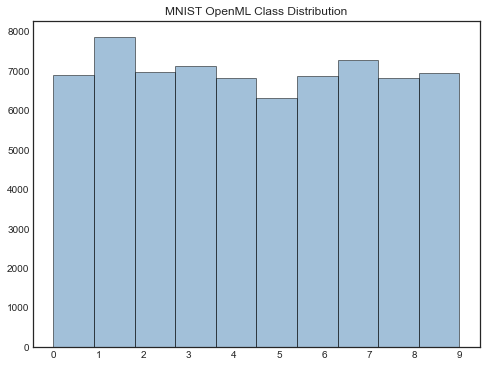

In [16]:
plt.figure(figsize=(8, 6))
plt.hist(list(counter.elements()), bins=10, 
         facecolor='steelblue', edgecolor='k', alpha=0.5)
plt.title('MNIST OpenML Class Distribution')
plt.xticks(np.arange(10))
plt.show()

###### Note on Performance

In case your machine is struggling with the computation included in this notebook, you could 
alternatively substitute the full **real world** MNIST dataset with its "toy" version as provided by the 
`load_digits` function included in `sklearn`.

This will drastically speed-up the computation, although reducing the quality of the results. 

Here is a comparison of the two datasets:

(A) **MNIST** (`fetch_openml`): `70,000` samples, $28 \times 28$ images;

(B) **DIGITS** (`load_digits`): `1,797` samples, $8 \times 8$ each 

In [17]:
# Load digits, and compare class distributions
from sklearn.datasets import load_digits

X_small, y_small = load_digits(return_X_y=True)

print("X_small shape: ", X_small.shape)
print("y_small shape: ", y_small.shape)

X_small shape:  (1797, 64)
y_small shape:  (1797,)


In [18]:
counter_digits = Counter(y_small)

In [19]:
counter_digits

Counter({0: 178,
         1: 182,
         2: 177,
         3: 183,
         4: 181,
         5: 182,
         6: 181,
         7: 179,
         8: 174,
         9: 180})

In [20]:
counter_digits.most_common(3)

[(3, 183), (1, 182), (5, 182)]

Let's have a look at the distribution of samples per class in the **digits** dataset:

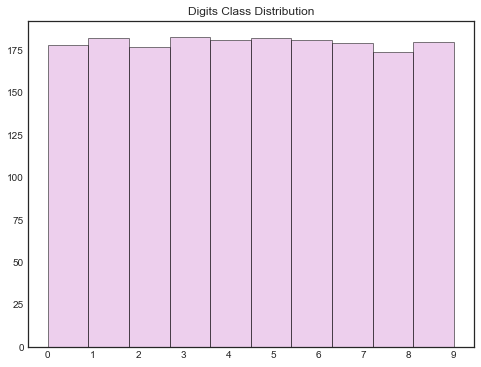

In [21]:
plt.figure(figsize=(8, 6))
plt.hist(list(counter_digits.elements()), bins=10, 
         facecolor="plum", edgecolor="k", alpha=0.5)
plt.title('Digits Class Distribution')
plt.xticks(np.arange(10))
plt.show()

As expected, this "toy" version of the dataset contains a more balanced distribution of samples 
per class than the original dataset.

In [22]:
## UNCOMMENT the following lines to use DIGITS instead of OpenML MNIST in the rest of the notebook.
# X, y = X_small, y_small
# IMG_SIZE = (8, 8)

#### Dataset Partitioning

Before we proceed further on applying **dimensionality reduction** techniques on the MNIST dataset, we will partion the dataset into two _disjoint_ datasets, namely **training** and **test** sets.

To do so, we will leverage on the `train_test_split` function of `sklearn`:

In [23]:
from sklearn.model_selection import train_test_split

We will pass in input the data and the corresponding labels to partition, along with 
`test_size` ($\in [0, 1)$) indicating the percentage of samples to randomly assign to the test 
set partition. The function also accepts a `stratify` parameter, used to balance the distribution of 
samples per-classes in the two partitions. 

![train_test_split](./images/train_test_split.svg)

In [24]:
# Load the datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, 
                                                    stratify=y, random_state=7)

In [25]:
# Verify shape of datasets
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (52500, 784)
Shape of y_train:  (52500,)
Shape of X_test:  (17500, 784)
Shape of y_test:  (17500,)


##### Visualising samples

Let's now visualise some samples extracted from the two partitions, along with their corresponding label.

To do so, we will write an helper function (`view(digit, dataset)`) that shows samples 
of specified digits as randomly extracted from a target dataset partition, i.e. a (`X`, `y`) pair.

In [26]:
def generate_samples(digit, partition, seed=123456):
    """Generate samples of target digit class, randomly extracted from target partition
    
    Parameters
    ----------
    digit: int
        The target MNIST digit class of samples.
    partition: tuple
        A (X, y) pair corresponding to target data partition
    seed: int (default 7)
        The random seed to use for samples shuffling
    
    Yields
    ------
    int
        sample index
    int
        sample label (will correspond to digit)
    numpy.ndarray
        sample image, already reshaped according to IMG_SIZE
    """
    X, y = partition
    samples_indices = np.where(y == digit)[0]
    rng = np.random.default_rng(seed=seed)
    rng.shuffle(samples_indices)  # Shuffle indices
    for idx in samples_indices:
        label = y[idx]
        image = X[idx,:].reshape(IMG_SIZE)
        yield idx, label, image
    
from mpl_toolkits.axes_grid1 import ImageGrid

def view(digit, partition=(X_train, y_train), dataset="training", grid_size=(3, 3)):
    fig = plt.figure(figsize=(8., 8.))
    plt.suptitle(f"Samples from {dataset} partition for digit {digit}")
    grid = ImageGrid(fig, 111,
                     nrows_ncols=grid_size,  
                     axes_pad=0.3,  # pad between axes in inch.
                     )
    
    samples = generate_samples(digit, partition)
    len_samples = grid_size[0] * grid_size[1]
    for ax, im in zip(grid, range(len_samples)):
        # Iterating over the grid returns the Axes.
        idx, label, im = next(samples)
        ax.set_title(f"Example: {idx}  Label: {label}")
        ax.imshow(im)
        
    plt.axis('off')
    plt.show()

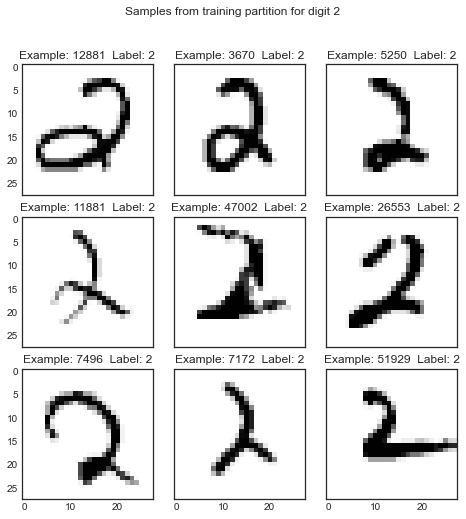

In [27]:
view(2, partition=(X_train, y_train), dataset="training")

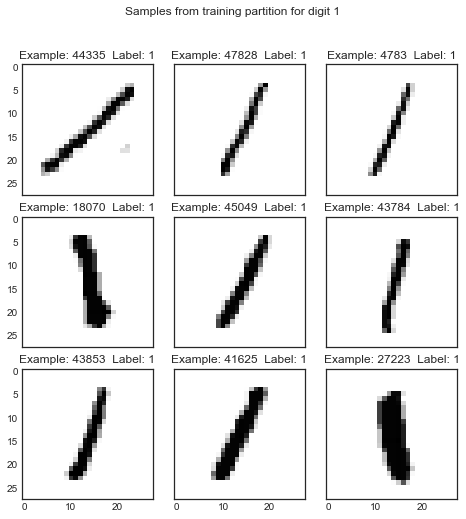

In [28]:
view(1, partition=(X_train, y_train), dataset="training")

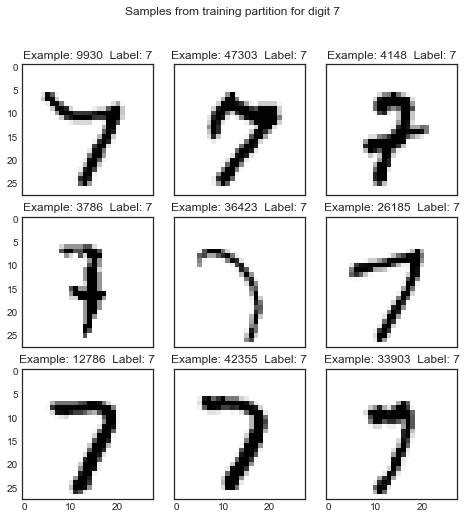

In [29]:
view(7)

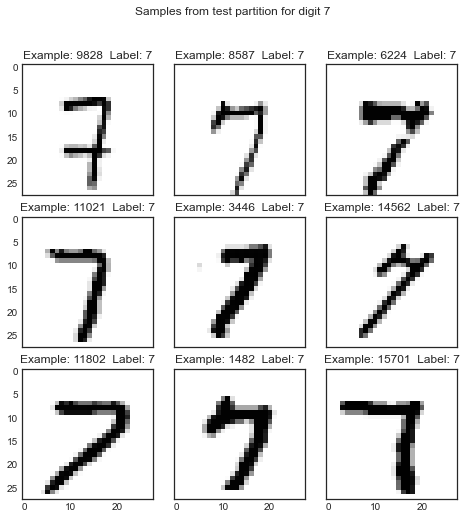

In [30]:
view(7, dataset="test", partition=(X_test, y_test))

### Projection Methods (Matrix Factorization)

<img src="images/projection.png" title="Projection-based Methods" />

<img src="images/projection_2.png" title="Projection-based Methods" />

$$
X \approx UV
$$

**where** 
- $X$ is a $N \times D$ matrix
- $U$ is a $N \times d$ matrix
- $V$ is a $d \times D$ matrix

Therefore, the very idea is to **minimise** _some_ loss so that
$$
\sum_{i=1}^{N}\sum_{j=1}^{D} \mathcal{L} ( X_{ij}, (UV)_{ij} )
$$
_subject to constraints..._

<span class="fn"><i>Credits: </i> Leland McInnes</span>

#### Principal Component Analysis

**Short Description**

`PCA` is one of the most common linear dimensionality reduction techniques. In PCA, the algorithm finds a low-dimensional representation of the data while retaining as much of the variation (i.e. _salient information_) as possible.

PCA does this by addressing the correlation among features. 

If the correlation is very high among a subset of the features, PCA will attempt to combine the highly correlated features and represent this data with a smaller number of **linearly** uncorrelated features.

The algorithm keeps performing this correlation reduction, finding the directions of maximum variance in the original high-dimensional data and projecting them onto a smaller dimensional space. These newly derived components are known as **principal components**.

<span class="fn"><i>Source: </i> Exceprt extracted from **Hands-On Unsupervised Learning Using Python** by _A. Patel_</span>

With these components, it is possible to reconstruct the original features — not exactly but generally close enough. 
The PCA algorithm actively attempts to **minimize** the reconstruction error during its search for the optimal components.

And speaking of _minimisation_:

$$
\sum_{i=1}^{N}\sum_{j=1}^{D} ( X_{ij} - (UV)_{ij} )^2
$$

_with no constraints_

There is indeed an awful lot we can do with _mean squared error_

In fact, what if we want to constrain *how many archetypes* can be combined?

(**SparcePCA**)

$$
\sum_{i=1}^{N}\sum_{j=1}^{D} ( X_{ij} - (UV)_{ij} )^2
$$
_subject to_
- $||U||_2 = 1$ (Unit vector)
- $||U||_0 \leq k$ (i.e. no. of non-zero components)

_but also_

$$
\sum_{i=1}^{N}\sum_{j=1}^{D} ( X_{ij} - (UV)_{ij} )^2
$$
_subject to_
- $||U||_2 = 1$ 
- $||U||_0 = 1$ 

(**K-Means Clustering**)

##### PCA in Practice

Now, let’s apply PCA to the MNIST digits dataset and see how well PCA captures the most salient information about the digits as its projects the data from the original `784`-dimensional space to a lower dimensional space.

In [31]:
# Principal Component Analysis
from sklearn.decomposition import PCA

n_components = 784
whiten = False
random_state = 123456

pca = PCA(n_components=n_components, whiten=whiten, random_state=random_state)

In [33]:
X_train_PCA = pca.fit_transform(X_train)

In [34]:
# Percentage of Variance Captured by 784 principal components
print("Variance Explained by all 784 principal components: ", sum(pca.explained_variance_ratio_))

Variance Explained by all 784 principal components:  0.9999999999999999


In [35]:
pca_explained_var = pca.explained_variance_ratio_

In [36]:
for no_comps in (10, 20, 50, 100, 200, 300):
    print(f"Variance Captured by the first {no_comps} Principal Components: ", 
          pca_explained_var[:no_comps].sum())

Variance Captured by the first 10 Principal Components:  0.48954869793789046
Variance Captured by the first 20 Principal Components:  0.6449423532133546
Variance Captured by the first 50 Principal Components:  0.8256909504222977
Variance Captured by the first 100 Principal Components:  0.9150751298376101
Variance Captured by the first 200 Principal Components:  0.9665909688528755
Variance Captured by the first 300 Principal Components:  0.9863018965221538


Helper function to draw the scatter plots (using `sns.lmplot`)

In [37]:
def scatter_plot(X_trans, y, method_name):
    y = pd.Series(y, dtype="category")
    trans_df = pd.DataFrame(data={"First Component": X_trans[:, 0],
                                  "Second Component": X_trans[:, 1], 
                                  "Label": y})
    sns.lmplot(x="First Component", y="Second Component", 
               hue="Label", data=trans_df, fit_reg=False, 
               height=10, palette="colorblind")
    ax = plt.gca()
    ax.set_title(f"Separation of Observations using {method_name}")
    plt.show()

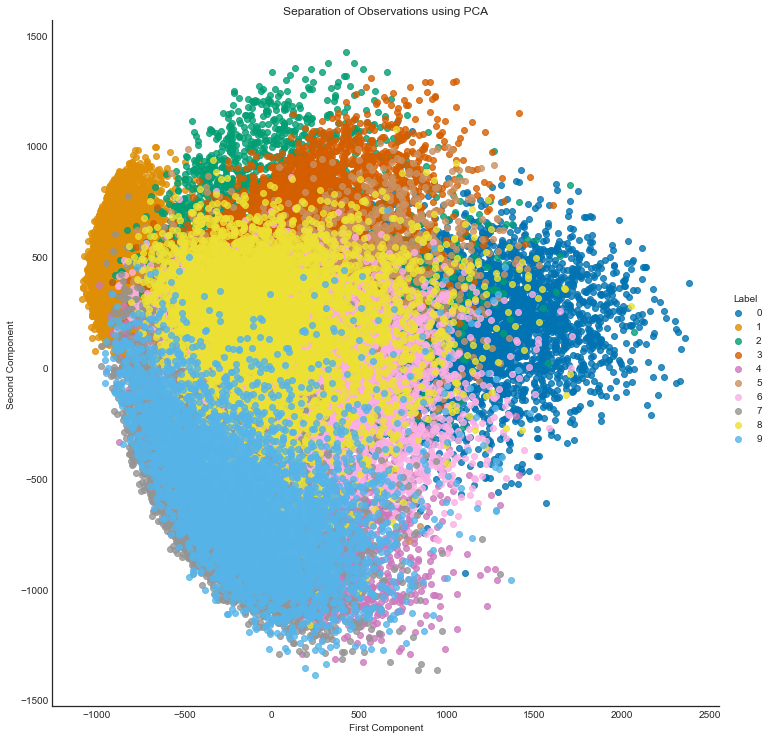

In [38]:
scatter_plot(X_train_PCA, y_train, "PCA")

###### Original Feature Set

As a comparison, let's draw how samples are separated in the original feature set, by simply considering the two features corresponding to the highest variance

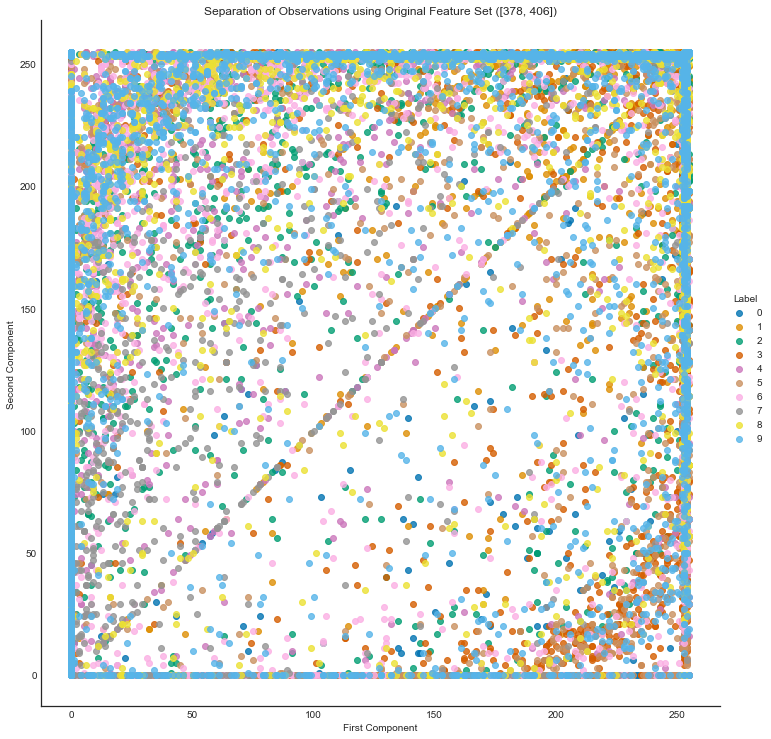

In [39]:
top_var_features = X_train[:, ].var(axis=0).argsort()[::-1][:2]
X_orig = X_train[:, top_var_features]
scatter_plot(X_orig, y_train, f"Original Feature Set ({top_var_features.tolist()})")

### Manifold Learning

While PCA is often a good first approach for transforming your data so that you might be able to visualize it using a scatter plot, the nature of the method (applying a rotation and then dropping directions) limits its usefulness.

**Manifold learning** methods for dimensionality reduction are based on the _manifold assumption_ [[2]](#ref2) which postulates the existence of low-dimensional manifolds, where the embedded information is concentrated.

**Multidimensional Scaling** (`MDS`) and **Isometric Feature Map** (`IsoMap`) are among the most commonly used non-linear dimensionality reduction techniques.


<span id="ref2" class="fn"><i>[2]:</i> Tenenbaum, J. B., Silva, V. de & Langford, J. C. A Global Geometric Framework for Nonlinear Dimensionality Reduction. Science 290, 2319–2323 (2000).</span>

##### Multi dimensional Scaling

Multidimensional scaling (`MDS`) aims at identifying the level of similarity between the samples in a dataset, translating their pairwise _distances_ into a configuration of `n` points mapped into an abstract Cartesian space.

More technically, given a distance matrix (or a general notion of _distance_ among samples and so their features), and a chosen number of dimensions $N$ (`n_components`):

the `MDS` algorithm places each object into `N-dimensional` space such that the between-object distances are preserved as well as possible.

In [40]:
# Multidimensional Scaling
from sklearn.manifold import MDS

n_components = 2
n_init = 12
max_iter = 1200
metric = True
n_jobs = 4
random_state = 123456

mds = MDS(n_components=n_components, n_init=n_init, max_iter=max_iter, \
          metric=metric, n_jobs=n_jobs, random_state=random_state)

# for the sake of performance, 
# let's limit MDS computation to the first batch of 1,000 samples 
X_train_mds = mds.fit_transform(X_train[:1000,:])

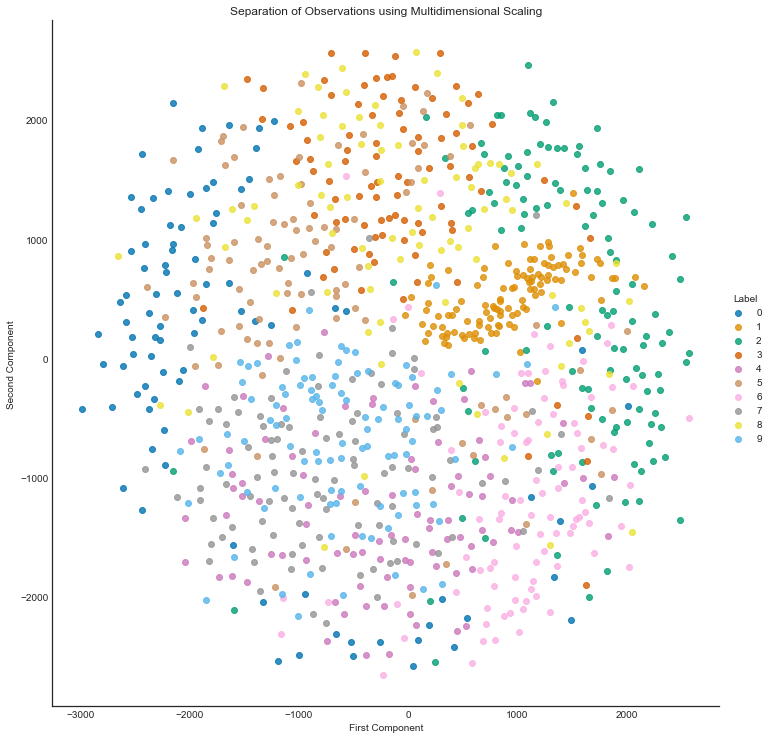

In [41]:
scatter_plot(X_train_mds, y_train[:1000], "Multidimensional Scaling")

##### Isometric Feature Mapping 

Isometric Feature Mapping (`IsoMap`) provides a simple method for estimating the intrinsic geometry of a data manifold based on a rough estimate of each data point’s neighbors on the manifold. 

Isomap extends multidimensional scaling by incorporating the **geodesic** distances imposed by a weighted graph, namely the distance between two vertices is expressed as the number of edges in a shortest path. 

To be specific, the classical scaling of metric MDS performs low-dimensional embedding based on the pairwise distance between data points, which is generally measured using straight-line Euclidean distance. 

Isomap is distinguished by its use of the **geodesic distance** induced by a neighbourhood graph embedded in the classical scaling. 

This is done to incorporate manifold structure in the resulting embedding. 

Isomap defines the geodesic distance to be the sum of edge weights along the shortest path between two nodes (computed using Dijkstra's algorithm, for example). 

**Algorithm in short**

1. Determine the neighbors of each point.
    - All points in some fixed radius.
    - K-nearest neighbors.
2. Construct a neighborhood graph.
    - Each point is connected to other if it is a K nearest neighbor.
    - Edge length equal to Euclidean distance.
3. Compute shortest path between two nodes.
    - Dijkstra's algorithm
    - Floyd–Warshall algorithm
4. Compute lower-dimensional embedding.
    - Multidimensional scaling

<span class="fn"><i>Source:</i> [Wikipedia Isomap](https://en.wikipedia.org/wiki/Isomap)</span>

In [46]:
# Multidimensional Scaling
from sklearn.manifold import Isomap

n_components = 2
n_neighbours = 30
n_jobs = 4
metric = "minkowski"

isomap = Isomap(n_components=n_components, n_neighbors=n_neighbours, n_jobs=n_jobs, metric=metric)

# for the sake of performance, 
# let's limit Isomap computation to the first batch of 1,000 samples 
X_train_isomap = isomap.fit_transform(X_train[:1000, :])

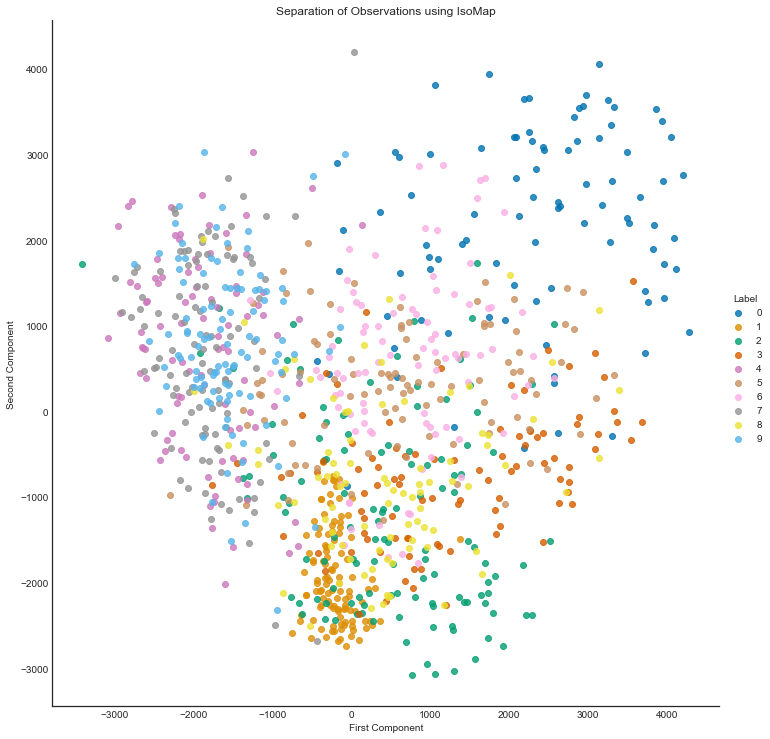

In [47]:
scatter_plot(X_train_isomap, y_train[:1000], "IsoMap")

##### t-distributed Stochastic Neighbor Embedding

The idea behind t-SNE is to find a two (or three) dimensional representation of the data that 
preserves the distances between points as best as possible, so that similar points are modeled close to each other and dissimilar points are modeled farther away.

In more details, t-SNE starts with a random representation for each data point, and then tries to make points that are close in the original feature space closer, and points that are far apart in the original feature space farther apart. t-SNE puts more emphasis on points that are close by, rather than preserving distances between far-apart points. In other words, it tries to preserve the information indicating which points are neighbors to each other.

It does this by constructing two probability distributions, one over pairs of points in the high-dimensional space and another over pairs of points in the low-dimensional space such that similar points have a high probability and dissimilar points have a lower probability.

Specifically, t-SNE minimizes the _Kullback–Leibler_ divergence between the two probability distributions.


In [48]:
# t-SNE
from sklearn.manifold import TSNE

n_components = 2
learning_rate = 300
perplexity = 30
early_exaggeration = 12
init = 'pca'
random_state = 123456

tSNE = TSNE(n_components=n_components, learning_rate=learning_rate, \
            perplexity=perplexity, early_exaggeration=early_exaggeration, \
            init=init, random_state=random_state)

# for the sake of performance, 
# let's limit MDS computation to the first batch of 1,000 samples 
X_train_tSNE = tSNE.fit_transform(X_train[:1000])

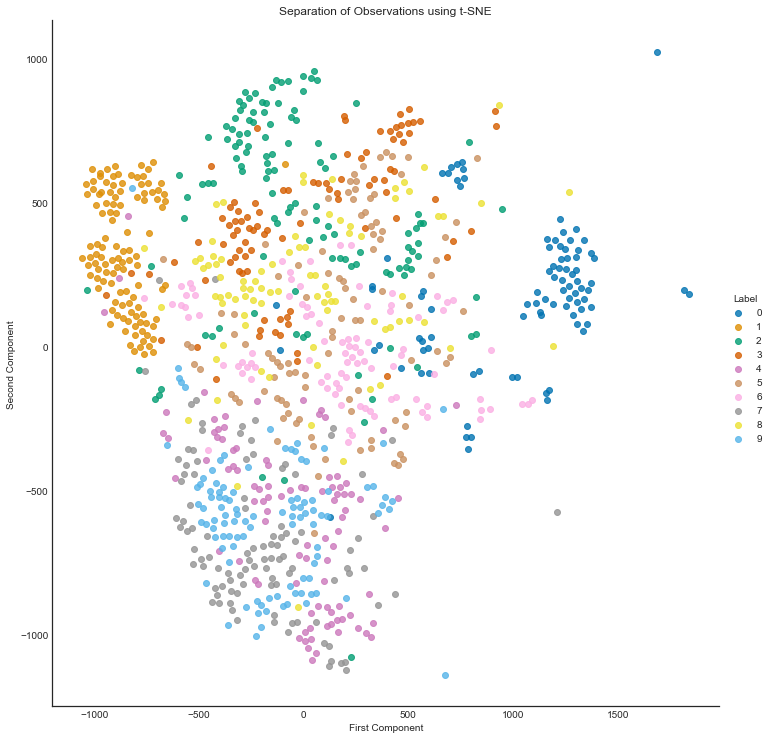

In [49]:
scatter_plot(X_train_tSNE, y_train[:1000], "t-SNE")

##### More about t-SNE

- [How to use t-SNE effectively](https://distill.pub/2016/misread-tsne/)
- (Paper) [Initialization is critical for preserving global data structure in both t-SNE and UMAP](https://www.nature.com/articles/s41587-020-00809-z)
    - also `sklearn` [Issue #18018](https://github.com/scikit-learn/scikit-learn/issues/18018)

---

#### Uniform Manifold Approximation and Projection for Dimension Reduction (`UMAP`)

Uniform Manifold Approximation and Projection (`UMAP`) is a dimensionality reduction technique founded on three main assumptions about the data:

- The data is uniformly distributed on [Riemannian manifold](https://en.wikipedia.org/wiki/Riemannian_manifold);
- The Riemannian metric is locally constant (or can be approximated as such);
- The manifold is locally connected.

From these assumptions it is possible to model the manifold with a fuzzy topological structure. 

The embedding is found by searching for a low dimensional projection of the data that has the closest possible equivalent fuzzy topological structure.
The details for the underlying mathematics can be found in the original paper on [ArXiv](https://arxiv.org/abs/1802.03426) [[3]](#ref3).
The software is available on [github](https://github.com/lmcinnes/).

From an algorithmic perspective, UAMP is comprised of two main steps: 

1. Compute a graph representing the data
2. Learn an embedding for that graph

![umap](https://umap-learn.readthedocs.io/en/latest/_images/umap-only.png)

<span class="fn" id="ref3"><i>[3]: </i>McInnes, L, Healy, J, UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction, ArXiv e-prints 1802.03426, 2018
</span>
<span class="fn"><i>Source: </i> UMAP official documentation on [ReadTheDocs](https://umap-learn.readthedocs.io/en/latest/)</span>

##### Basic UMAP Parameters

UMAP is a fairly flexible non-linear dimension reduction algorithm. It seeks to learn the manifold structure of your data and find a low dimensional embedding that preserves the essential topological structure of that manifold.

UMAP has several hyperparameters that can have a significant impact on the resulting embedding. In this notebook we will be covering the four major ones:

- `n_neighbors`
- `min_dist`
- `n_components`
- `metric`

###### `n_neighbors` (default `15`)

This parameter controls how UMAP balances **local** versus **global** structure in the data. 

It does this by constraining the size of the local neighborhood UMAP will look at when attempting to learn the manifold structure of the data. 

This means that low values of `n_neighbors` will force `UMAP` to concentrate on very local structure (potentially to the detriment of the big picture), while large values will push `UMAP` to look at larger neighborhoods of each point when estimating the manifold structure of the data, losing fine detail structure for the sake of getting the broader of the data.

###### `min_dist` (default `0.1`)

The effective minimum distance between embedded points. Smaller values will result in a more clustered/clumped embedding where nearby points on the manifold are drawn closer together, while larger values will result on a more even dispersal of points. The value should be set relative to the ``spread`` value, which determines the scale at which embedded points will be spread out.

###### `n_components` (default `2`)

The dimension of the space to embed into. This defaults to 2 to
        provide easy visualization, but can reasonably be set to any
        integer value in the range 2 to 100.

###### `metric` (default `euclidean`)

This parameter controls how distance is computed in the ambient space of the input data. By default UMAP supports a wide variety of metrics (see [here](https://umap-learn.readthedocs.io/en/latest/parameters.html#metric) for a full list) depending your dealing with _continuous_ or _binary_ data. Custom metrics can also be included.

**Note**: To run the rest of this notebook, `umap-learn` package is required.
To double-check whether this is installed or not, please run in your terminal:

```bash
pip install umap-learn
```

or 
```bash
conda install -c conda-forge umap-learn
```

In [50]:
version = lambda p: print(f"{p.__name__}: {p.__version__}")
try: 
    import umap
except ImportError:
    print("Please install umap-learn to run this notebook: pip install umap-learn")
else:
    version(umap)

umap: 0.5.1


In [51]:
from umap import UMAP

n_components = 2
metric="euclidean"
init="spectral"
random_state=42

umap = UMAP(n_components=n_components, metric=metric, 
            init=init, random_state=random_state)

# If this takes too much, restrict UMAP to the first 1K samples
X_train_umap = umap.fit_transform(X_train)

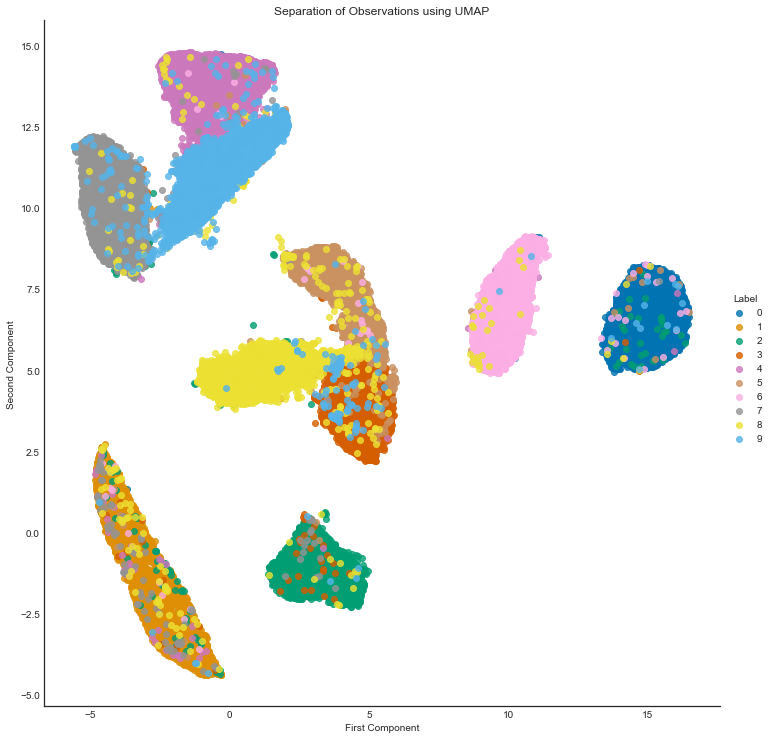

In [52]:
scatter_plot(X_train_umap, y_train, "UMAP")

Differently from t-SNE, another **important** feature of UMAP is the possibility of applying the **same** *trained* transformer to the **test** set. 

This is particularly crucial to study generalisability of models and transformers.

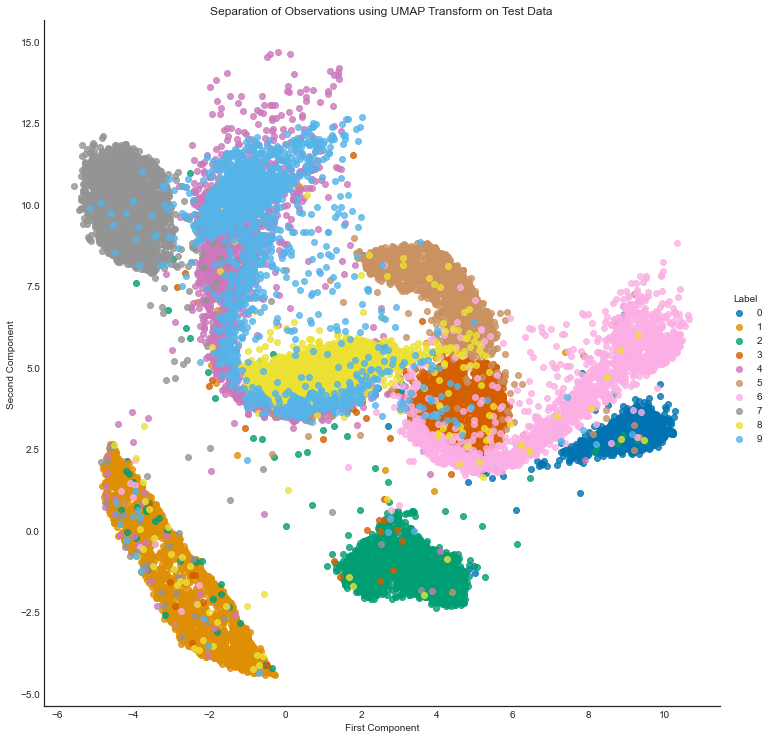

In [53]:
X_test_umap = umap.transform(X_test)
scatter_plot(X_test_umap, y_test, "UMAP Transform on Test Data")

**Supervised Dimensionality Reduction**

Also, in `umap` is also possible to pass in labels to better guide original embedding 

In [54]:
X_train_umap_with_labels = umap.fit_transform(X_train, y_train)

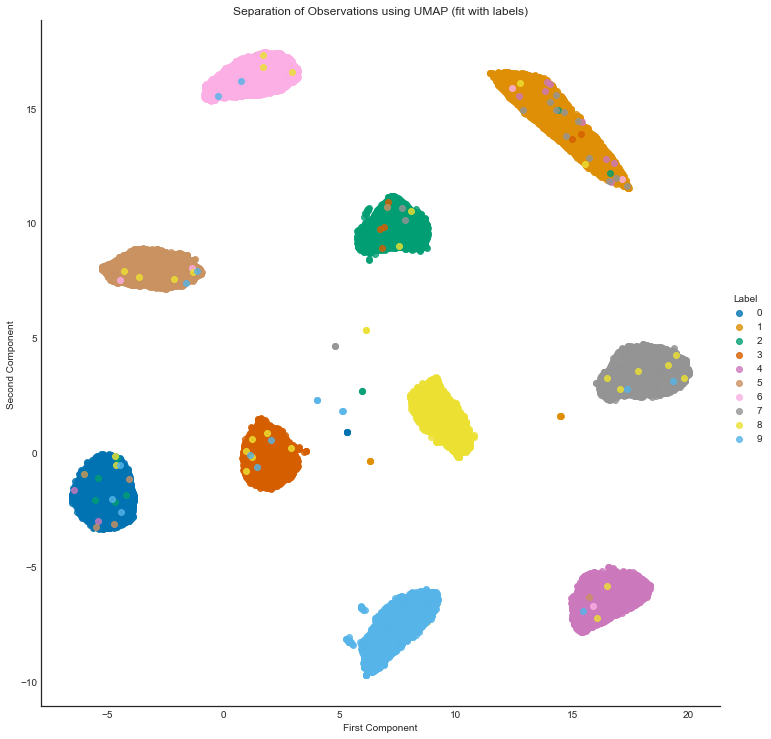

In [55]:
scatter_plot(X_train_umap_with_labels, y_train, "UMAP (fit with labels)")

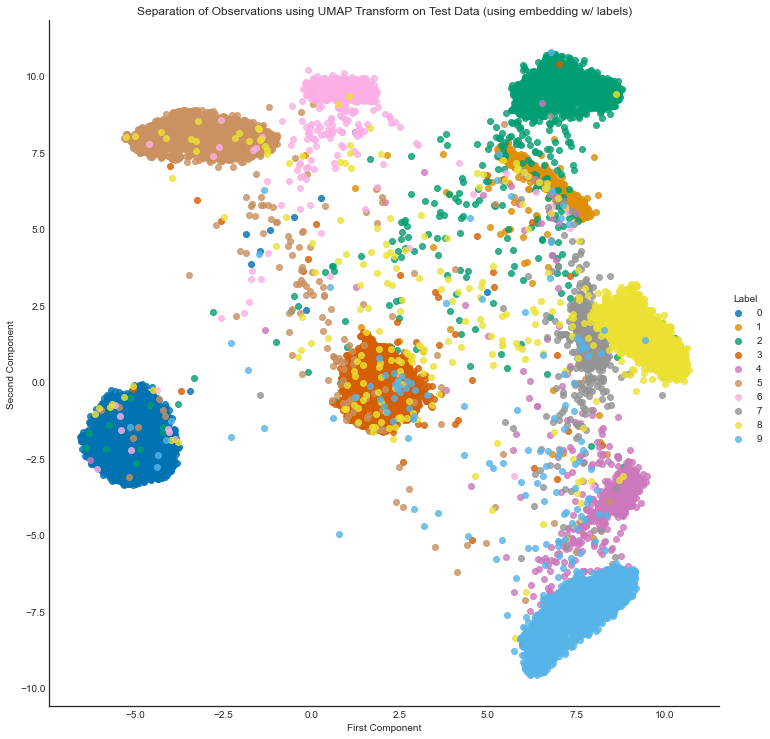

In [56]:
X_test_umap = umap.transform(X_test)
scatter_plot(X_test_umap, y_test, "UMAP Transform on Test Data (using embedding w/ labels)")

---

## References and Further Readings

- [[Book]](https://www.oreilly.com/library/view/hands-on-unsupervised-learning/9781492035633/) **Hands-On Unsupervised Learning Using Python** by _A. Patel_.

- [Paper] Tenenbaum, J. B., Silva, V. de & Langford, J. C. A Global Geometric Framework for Nonlinear Dimensionality Reduction. Science 290, 2319–2323 (2000).
- [Paper] McInnes, L., Healy, J. & Melville, J. UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction. Arxiv (2018).
  
  